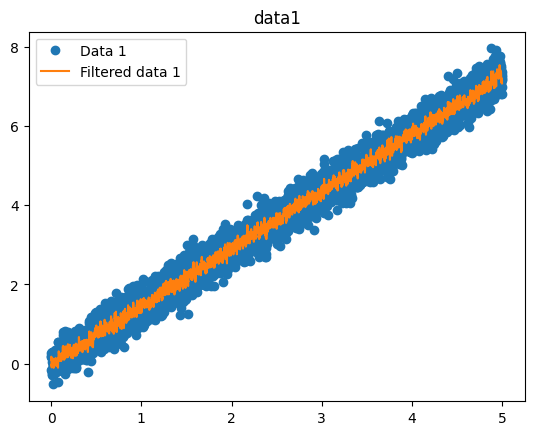

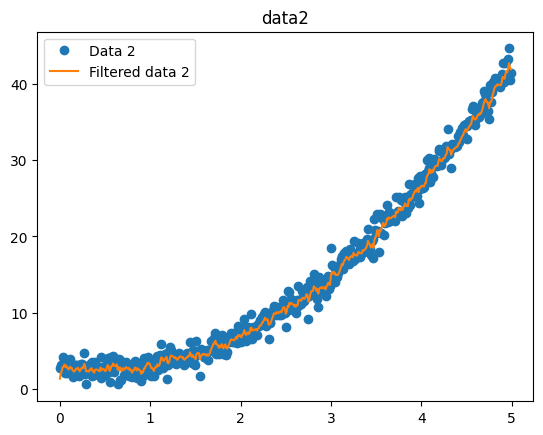

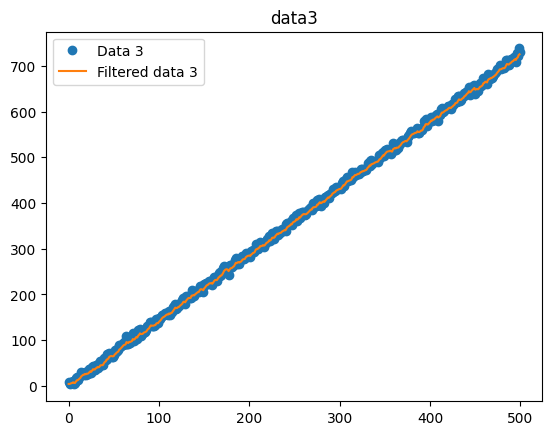

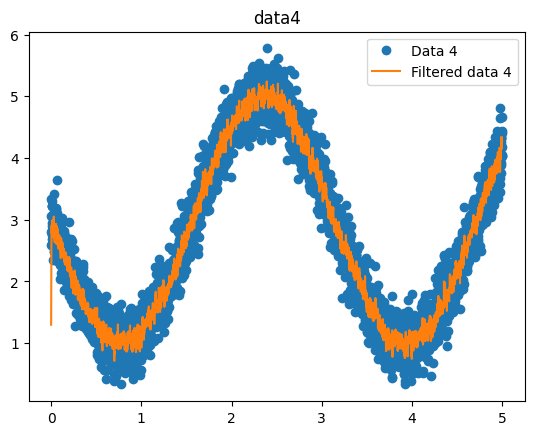

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data1 = pd.read_csv('./source/homework_data_1.txt', sep=' ')
data2 = pd.read_csv('./source/homework_data_2.txt', sep=' ')
data3 = pd.read_csv('./source/homework_data_3.txt', sep=' ')
data4 = pd.read_csv('./source/homework_data_4.txt', sep=' ')


from pykalman import KalmanFilter

# 定义转移矩阵
transition_matrix = np.array([[1, 0], [0, 1]])

# 定义观测矩阵
observation_matrix = np.array([[1, 0]])

# 定义过程噪声协方差
transition_covariance = 0.1 * np.eye(2)

# 定义观测噪声协方差
observation_covariance = 1

# 定义初始状态
initial_state_mean = [0, 0]
initial_state_covariance = np.ones((2, 2))

# 实例化KalmanFilter
kf = KalmanFilter(
    transition_matrices=transition_matrix,
    observation_matrices=observation_matrix,
    transition_covariance=transition_covariance,
    observation_covariance=observation_covariance,
    initial_state_mean=initial_state_mean,
    initial_state_covariance=initial_state_covariance
)

# 使用KalmanFilter进行拟合
filtered_state_means1, _ = kf.filter(data1['y'])
filtered_state_means2, _ = kf.filter(data2['y'])
filtered_state_means3, _ = kf.filter(data3['y'])
filtered_state_means4, _ = kf.filter(data4['y'])

# 绘制拟合结果
plt.figure()
plt.plot(data1['x'], data1['y'], 'o', label='Data 1')
plt.plot(data1['x'], filtered_state_means1[:, 0], label='Filtered data 1')
plt.title('data1')
plt.legend()

plt.figure()
plt.plot(data2['x'], data2['y'], 'o', label='Data 2')
plt.plot(data2['x'], filtered_state_means2[:, 0], label='Filtered data 2')
plt.title('data2')
plt.legend()

plt.figure()
plt.plot(data3['x'], data3['y'], 'o', label='Data 3')
plt.plot(data3['x'], filtered_state_means3[:, 0], label='Filtered data 3')
plt.title('data3')
plt.legend()

plt.figure()
plt.plot(data4['x'], data4['y'], 'o', label='Data 4')
plt.plot(data4['x'], filtered_state_means4[:, 0], label='Filtered data 4')
plt.title('data4')
plt.legend()

plt.show()

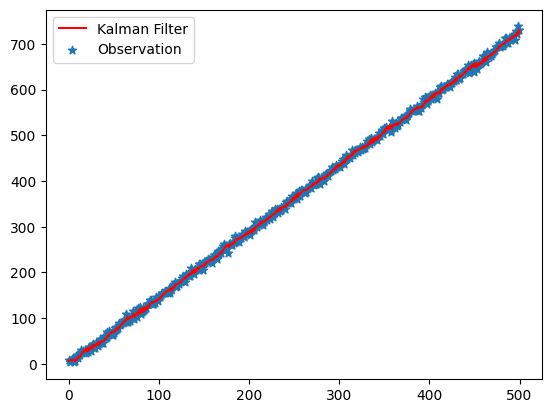

[[0.36138002]
 [0.07619427]
 [0.00799137]]


In [2]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jul  4 17:15:01 2022

@author: ThinkPad
"""


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#一步预测
'''
设状态量有xn个
- X0为前一时刻状态量，shape=(xn,1)
- P0为初始状态不确定度， shape=(xn,xn)
- A为状态转移矩阵，shape=(xn,xn)
- Q为递推噪声协方差矩阵，shape=(xn,xn)
- B、U1是外部输入部分

返回的结果为
- X10为一步预测的状态量结果，shape=(xn,1)
- P10为一步预测的协方差，shape=(xn,xn)
'''
def kf_predict(X0, P0, A, Q, B, U1):
    X10 = np.dot(A,X0) + np.dot(B,U1)
    P10 = np.dot(np.dot(A,P0),A.T)+ Q
    return (X10, P10)

'''
设状态量有xn个
- X10为一步预测的状态量结果，shape=(xn,1)
- P10为一步预测的协方差，shape=(xn,xn)
- Z为观测值，shape=(xn,1)
- H为观测系数矩阵，shape=(xn,xn)
- R为观测噪声协方差，shape=(xn,xn)

返回的结果为
- X1为一步预测的状态量结果，shape=(xn,1)
- P1为一步预测的协方差，shape=(xn,xn)
- K为卡尔曼增益，不需要返回，但是可以看一下它的值来判断是否正常运行
'''
#测量更新
def kf_update(X10, P10, Z, H, R):
    K = np.dot(np.dot(P10,H.T),np.linalg.pinv(np.dot(np.dot(H,P10),H.T) + R))
    X1 = X10 + np.dot(K,Z - np.dot(H,X10))
    P1 = np.dot(np.eye(K.shape[0]) - np.dot(K,H),P10)
    return (X1, P1, K)


data = pd.read_csv('./source/homework_data_3.txt', sep=' ')

y = data["y"]

n = data.shape[0] #数据量
nx = 3 #变量数量
t = data["x"] #时间序列
dt = t[1] - t[0] #t的一阶导



# 观测噪声协方差！！！！！！！！！！！！！！！！！！！！（可调整）
R = np.diag([10**2])

# 计算系数
# 状态转移矩阵
A = np.array([1,dt, 1,
              0, 1, dt,
              0, 0, 1]).reshape([nx,nx])
# 外部输入量
B = 0
U1 = 0

#状态假设（观测）初始值
x0 = y.head().mean()
v0 = (y[5:10].mean() - y[0:5].mean()) / 5
a0 = 0.0
X0 = np.array([x0,v0,a0]).reshape(nx,1)

#初始状态不确定度！！！！！！！！！！！！！！！！（可调整）
P0 = np.diag([10,10,1])

#状态递推噪声协方差！！！！！！！！！！！！！！！！！！（可调整）
Q = np.diag([0.1,0.1,0.01])

###开始处理
X1_np = np.copy(X0)
P1_list = [P0]
X10_np = np.copy(X0)
P10_list = [P0]

for i in range(n):
    Zi = np.array(y[i]).reshape([1,1])
    Hi = np.array([1,0,0]).reshape([1,nx])

    Xi = X1_np[:,i-1].reshape([nx,1])
    Pi = P1_list[i-1]
    X10, P10 = kf_predict(Xi, Pi, A, Q, B, U1)

    X10_np = np.concatenate([X10_np, X10], axis=1)
    P10_list.append(P10)

    X1, P1, K = kf_update(X10, P10, Zi, Hi, R)
    X1_np = np.concatenate([X1_np, X1], axis=1)
    P1_list.append(P1)

#结束，绘图
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.plot(X1_np[0,:], label="Kalman Filter", color = "red")
ax1.scatter(np.arange(n), y, label="Observation", marker='*')

plt.legend()
plt.show()

print(K)
